# Base Line - DenseNet201

## Step 1 - Import Dependencies

In [1]:
import torch
import torchvision # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
from torch.utils.data import Dataset
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import DataLoader  # Gives easier dataset managment by creating mini batches etc.

from torchsummary import summary


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from tqdm import tqdm  # For nice progress bar!
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, classification_report 

import matplotlib.pyplot as plt

/home/operation/miniconda3/envs/ds_bt_1/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/operation/miniconda3/envs/ds_bt_1/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Step 2 - The Model

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Hyperparameters
in_channels = 3
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 23

In [4]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet201', weights='IMAGENET1K_V1')

model

Using cache found in /home/operation/.cache/torch/hub/pytorch_vision_v0.10.0


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

## Freeze Early Layers

In [5]:
# Freeze early layers
for param in model.parameters():
    param.requires_grad = False

## Step 3 - Modify the Model

In [6]:
model.classifier = nn.Sequential(
                            nn.Linear(1920, 960),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(960, 240),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(240, 30),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(30, num_classes))

model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [7]:
# summary(model, input_size=(3, 224, 224), batch_size=batch_size)

## Step 4 - Create the Dataset

In [8]:
class Dataset(Dataset):
    def __init__(self, labels_file, root_dir, transform=None):
        self.annotations = pd.read_csv(labels_file, header=None)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, str(self.annotations.iloc[index, 1]), self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        image = image.convert("RGB")
        label = torch.tensor(int(self.annotations.iloc[(index, 2)]))

        if self.transform:
            image = self.transform(image)

        return(image, label)
    
    def __getlabel__(self, index):
        label = int(self.annotations.iloc[(index, 2)])        

        return(label)

In [9]:
preprocessing = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=3),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## Step 5 - Load the Data

### Train Dataset

In [10]:
#labels_file = '../gc10-det/02_raw_train/labels.csv'
#root_dir = '../gc10-det/02_raw_train/images/'

labels_file = '../gc10-det/03_augmented/1000/labels.csv'
root_dir = '../gc10-det/03_augmented/1000/images/'

trainDataset = Dataset(labels_file=labels_file, root_dir=root_dir, transform=preprocessing)

In [11]:
train_loader = DataLoader(dataset=trainDataset, batch_size=batch_size, shuffle=True)

### Test Dataset

In [12]:
labels_file = '../gc10-det/99_test/labels.csv'
root_dir = '../gc10-det/99_test/images/'

testDataset = Dataset(labels_file=labels_file, root_dir=root_dir, transform=preprocessing )

In [13]:
test_loader = DataLoader(dataset=testDataset, batch_size=batch_size, shuffle=True)

## Step 6 -  Initialize & Train

In [14]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
# Train Network

train_losses = []
train_batch_losses = []

val_losses = []
val_batch_losses = []

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (image, label) in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible
        image = image.to(device=device)
        label = label.to(device=device)

        # forward
        preds = model(image) # Pass batch
        train_loss = criterion(preds, label) # Calculate the loss

        # backward
        optimizer.zero_grad() # 
        train_loss.backward() # Calculate the gradients

        # gradient descent or adam step
        optimizer.step() # Uptade the weights
        
        # store loss
        train_batch_losses.append(train_loss.item())
        
    train_losses.append(sum(train_batch_losses)/len(train_batch_losses))
    print (f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{n_total_steps}], Train Loss: {train_loss.item():.4f}')
        
    model.eval()
    for batch_idx, (image, label) in enumerate(tqdm(test_loader)):
        # Get data to cuda if possible
        image = image.to(device=device)
        label = label.to(device=device)

        # forward
        with torch.no_grad():
            preds = model(image) # Pass batch
            
        val_loss = criterion(preds, label) # Calculate the loss
        
        # store loss
        val_batch_losses.append(val_loss.item())
        
    val_losses.append(sum(val_batch_losses)/len(val_batch_losses))
    print (f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{n_total_steps}], Val Loss: {val_loss.item():.4f}')


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [12:18<00:00,  4.70s/it]


Epoch [1/23], Step [157/157], Train Loss: 1.8827


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:37<00:00,  4.66s/it]


Epoch [1/23], Step [8/157], Val Loss: 0.8494


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [12:37<00:00,  4.83s/it]


Epoch [2/23], Step [157/157], Train Loss: 0.7725


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:39<00:00,  4.91s/it]


Epoch [2/23], Step [8/157], Val Loss: 0.8365


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [12:39<00:00,  4.84s/it]


Epoch [3/23], Step [157/157], Train Loss: 0.9854


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:37<00:00,  4.64s/it]


Epoch [3/23], Step [8/157], Val Loss: 1.4243


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [12:36<00:00,  4.82s/it]


Epoch [4/23], Step [157/157], Train Loss: 1.1900


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:37<00:00,  4.67s/it]


Epoch [4/23], Step [8/157], Val Loss: 0.7772


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [12:37<00:00,  4.82s/it]


Epoch [5/23], Step [157/157], Train Loss: 1.5305


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:37<00:00,  4.72s/it]


Epoch [5/23], Step [8/157], Val Loss: 0.5513


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [12:31<00:00,  4.79s/it]


Epoch [6/23], Step [157/157], Train Loss: 0.7221


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:37<00:00,  4.64s/it]


Epoch [6/23], Step [8/157], Val Loss: 0.4268


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [12:33<00:00,  4.80s/it]


Epoch [7/23], Step [157/157], Train Loss: 0.8155


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:37<00:00,  4.67s/it]


Epoch [7/23], Step [8/157], Val Loss: 0.6618


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [12:44<00:00,  4.87s/it]


Epoch [8/23], Step [157/157], Train Loss: 0.3100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:37<00:00,  4.74s/it]


Epoch [8/23], Step [8/157], Val Loss: 0.3128


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [12:43<00:00,  4.86s/it]


Epoch [9/23], Step [157/157], Train Loss: 0.6893


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:38<00:00,  4.76s/it]


Epoch [9/23], Step [8/157], Val Loss: 0.9480


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [12:43<00:00,  4.86s/it]


Epoch [10/23], Step [157/157], Train Loss: 0.8974


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:37<00:00,  4.63s/it]


Epoch [10/23], Step [8/157], Val Loss: 0.4713


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [12:49<00:00,  4.90s/it]


Epoch [11/23], Step [157/157], Train Loss: 0.7418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:38<00:00,  4.85s/it]


Epoch [11/23], Step [8/157], Val Loss: 0.7398


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [12:35<00:00,  4.81s/it]


Epoch [12/23], Step [157/157], Train Loss: 1.2055


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:37<00:00,  4.70s/it]


Epoch [12/23], Step [8/157], Val Loss: 0.4165


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [12:41<00:00,  4.85s/it]


Epoch [13/23], Step [157/157], Train Loss: 0.9094


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:37<00:00,  4.69s/it]


Epoch [13/23], Step [8/157], Val Loss: 1.0254


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [12:43<00:00,  4.86s/it]


Epoch [14/23], Step [157/157], Train Loss: 1.0962


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:37<00:00,  4.66s/it]


Epoch [14/23], Step [8/157], Val Loss: 0.8976


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [12:43<00:00,  4.86s/it]


Epoch [15/23], Step [157/157], Train Loss: 0.8671


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:38<00:00,  4.76s/it]


Epoch [15/23], Step [8/157], Val Loss: 0.5716


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [12:41<00:00,  4.85s/it]


Epoch [16/23], Step [157/157], Train Loss: 0.9035


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:37<00:00,  4.69s/it]


Epoch [16/23], Step [8/157], Val Loss: 0.3991


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [12:43<00:00,  4.86s/it]


Epoch [17/23], Step [157/157], Train Loss: 1.3910


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:37<00:00,  4.67s/it]


Epoch [17/23], Step [8/157], Val Loss: 0.6648


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [12:44<00:00,  4.87s/it]


Epoch [18/23], Step [157/157], Train Loss: 0.4583


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:37<00:00,  4.75s/it]


Epoch [18/23], Step [8/157], Val Loss: 1.2133


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [12:41<00:00,  4.85s/it]


Epoch [19/23], Step [157/157], Train Loss: 0.4861


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:37<00:00,  4.68s/it]


Epoch [19/23], Step [8/157], Val Loss: 1.0766


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [12:40<00:00,  4.84s/it]


Epoch [20/23], Step [157/157], Train Loss: 0.8846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:37<00:00,  4.71s/it]


Epoch [20/23], Step [8/157], Val Loss: 0.7899


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [12:40<00:00,  4.84s/it]


Epoch [21/23], Step [157/157], Train Loss: 0.8192


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:37<00:00,  4.69s/it]


Epoch [21/23], Step [8/157], Val Loss: 1.0858


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [12:36<00:00,  4.82s/it]


Epoch [22/23], Step [157/157], Train Loss: 0.2282


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:37<00:00,  4.64s/it]


Epoch [22/23], Step [8/157], Val Loss: 0.3037


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [12:42<00:00,  4.86s/it]


Epoch [23/23], Step [157/157], Train Loss: 0.8349


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:37<00:00,  4.63s/it]

Epoch [23/23], Step [8/157], Val Loss: 0.7639


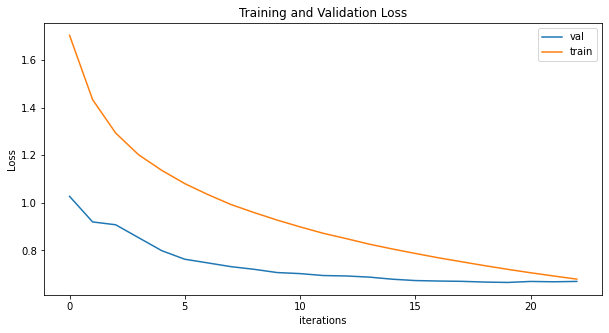

In [16]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Step 7 - Metrics

In [17]:
def get_all_preds(model, loader):
    y_test = torch.tensor([])
    y_pred = torch.tensor([])
    model.eval()
    
    with torch.no_grad():
        for batch in loader:
            image, label = batch
        
            preds = model(image)
            
            y_pred = torch.cat((y_pred, preds), dim=0)
            y_test = torch.cat((y_test, label), dim=0)
        
        y_pred = y_pred.argmax(dim=1)
        
    return y_pred, y_test

In [18]:
y_pred, y_test = get_all_preds(model, test_loader)

In [19]:
y_pred_train, y_train = get_all_preds(model, train_loader)

In [20]:
# Accuracy and F1-Score
print(f"Accuracy Train = {accuracy_score(y_train, y_pred_train)*100}%")
print(f'Macro f1_score Train = {f1_score(y_train, y_pred_train, average="macro")*100}%')

Accuracy Train = 92.64%
Macro f1_score Train = 92.58003809267343%


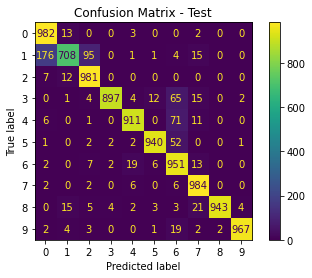

In [21]:
# Confusion Matrix
cm = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)

disp.plot()
plt.title("Confusion Matrix - Test")
plt.show()

In [22]:
# Accuracy and F1-Score
print(f"Accuracy Test = {accuracy_score(y_test, y_pred)*100}%")
print(f'Macro f1_score Test = {f1_score(y_test, y_pred, average="macro")*100}%')

Accuracy Test = 83.5117773019272%
Macro f1_score Test = 78.37364771858503%


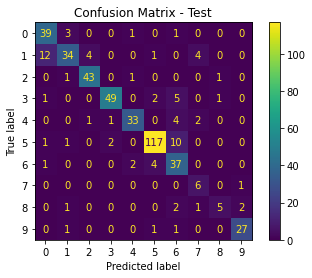

In [23]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)

disp.plot()
plt.title("Confusion Matrix - Test")
plt.show()

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.72      0.89      0.80        44
         1.0       0.83      0.62      0.71        55
         2.0       0.90      0.93      0.91        46
         3.0       0.94      0.84      0.89        58
         4.0       0.89      0.80      0.85        41
         5.0       0.94      0.89      0.91       131
         6.0       0.62      0.84      0.71        44
         7.0       0.46      0.86      0.60         7
         8.0       0.71      0.45      0.56        11
         9.0       0.90      0.90      0.90        30

    accuracy                           0.84       467
   macro avg       0.79      0.80      0.78       467
weighted avg       0.85      0.84      0.84       467

